# Import Packages & Loan Data 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000

# load loan data
df = pd.read_csv('LoanData.csv', low_memory=False)
print(df.shape)

(246624, 112)


## Add TARGET column for to mark loans that defaulted

In [2]:
# Add target column 

TARGET = []
for row in df['Status']:
    if row == 'Late' : TARGET.append(1)
    else: TARGET.append(0)

df['TARGET'] = TARGET
# df['TARGET'] = df.Status == 'Late'   # if boolean should be prefered

print(df.shape)

(246624, 113)


## Removing loans that are still going on 

In [3]:
df = df[df['Status'] != 'Current']
print(df.shape)
print(df.head())


(158922, 113)
  ReportAsOfEOD                                LoanId  LoanNumber  \
0    2022-07-23  66AE108B-532B-4BB3-BAB7-0019A46412C1      483449   
2    2022-07-23  D152382E-A50D-46ED-8FF2-0053E0C86A70      378148   
3    2022-07-23  87342E13-66CB-483F-833A-007953E50C78      451831   
4    2022-07-23  87227056-6BF9-410C-98D1-008F788E122A      349381   
5    2022-07-23  2DDE6336-E466-4624-A337-00A0ED1A1468      443082   

           ListedOnUTC     BiddingStartedOn  BidsPortfolioManager  BidsApi  \
0  2016-03-23 16:07:19  2016-03-23 16:07:19                   970   1150.0   
2  2015-06-25 11:02:28  2015-06-25 11:02:28                  1295      0.0   
3  2016-01-14 10:00:21  2016-01-14 10:00:21                  2700    565.0   
4  2015-03-24 15:55:44  2015-03-24 15:55:44                  1115      0.0   
5  2015-12-17 10:12:00  2015-12-17 10:12:00                   305      0.0   

   BidsManual                                 PartyId  NewCreditCustomer  \
0         5.0  {EBF05573-5

## Sorting columns & removing irrelevant data

In [4]:
relevantCols = [
    # APPLICATION
    'ApplicationSignedHour', 'ApplicationSignedWeekday', 'VerificationType', 
    
    # LOAN
    'AppliedAmount',
    
    # DEMOGRAPHIC
    'LanguageCode','Age','Gender','Country','LoanDuration', 'MonthlyPayment',  'UseOfLoan', 'Education', 
    'MaritalStatus', 'NrOfDependants', 'EmploymentStatus', 'EmploymentDurationCurrentEmployer', 'WorkExperience', 
    'OccupationArea', 'HomeOwnershipType', 
    
    # INCOME 
    'IncomeFromPrincipalEmployer','IncomeFromPension', 'IncomeFromFamilyAllowance', 'IncomeFromSocialWelfare', 
    'IncomeFromLeavePay', 'IncomeFromChildSupport', 'IncomeOther', 'IncomeTotal', 
    
    # LIABILITIES
    'ExistingLiabilities', 'LiabilitiesTotal', 'RefinanceLiabilities', 
    
    'DebtToIncome', 'FreeCash', 'MonthlyPaymentDay', 
    # PREV LOANS
    'NewCreditCustomer', 'NoOfPreviousLoansBeforeLoan', 'AmountOfPreviousLoansBeforeLoan', 
    'PreviousRepaymentsBeforeLoan', 'PreviousEarlyRepaymentsBefoleLoan', 'PreviousEarlyRepaymentsCountBeforeLoan',
]

relevantCols = [
    # APPLICATION
    'ApplicationSignedHour', 'ApplicationSignedWeekday', 'VerificationType', 
    
    # LOAN
    'AppliedAmount',
    
    # DEMOGRAPHIC
    'LanguageCode','Age','Gender','Country','LoanDuration', 'MonthlyPayment',  'UseOfLoan', 'Education', 
    'MaritalStatus', 'NrOfDependants', 'EmploymentStatus', 'EmploymentDurationCurrentEmployer', 'WorkExperience', 
    'OccupationArea', 'HomeOwnershipType', 
    
    # INCOME 
    'IncomeFromPrincipalEmployer','IncomeFromPension', 'IncomeFromFamilyAllowance', 'IncomeFromSocialWelfare', 
    'IncomeFromLeavePay', 'IncomeFromChildSupport', 'IncomeOther', 'IncomeTotal', 
    
    # LIABILITIES
    'ExistingLiabilities', 'LiabilitiesTotal', 'RefinanceLiabilities', 
    
    'DebtToIncome', 'FreeCash', 'MonthlyPaymentDay', 
    # PREV LOANS
    'NewCreditCustomer', 'NoOfPreviousLoansBeforeLoan', 'AmountOfPreviousLoansBeforeLoan', 
    'PreviousRepaymentsBeforeLoan', 'PreviousEarlyRepaymentsBefoleLoan', 'PreviousEarlyRepaymentsCountBeforeLoan',
]

df = df[relevantCols]
print(df.shape)

(158922, 39)


## Checking for empty cells

In [5]:
print(df.isna().sum())

ApplicationSignedHour                          0
ApplicationSignedWeekday                       0
VerificationType                              50
AppliedAmount                                  0
LanguageCode                                   0
Age                                            0
Gender                                        45
Country                                        0
LoanDuration                                   0
MonthlyPayment                              6668
UseOfLoan                                      0
Education                                     50
MaritalStatus                                 50
NrOfDependants                            124337
EmploymentStatus                             202
EmploymentDurationCurrentEmployer           1959
WorkExperience                            123444
OccupationArea                                91
HomeOwnershipType                           1657
IncomeFromPrincipalEmployer                    0
IncomeFromPension   

## Checking for incomplete rows 
A lot of lines have 50 empty cells. Those may be the same. 

In [6]:
susColumns = ['Education','MaritalStatus','DebtToIncome','VerificationType','FreeCash', 'Gender']

# get the numbers of rows that have empty cells in the sus columns
incompleteRows = []
for col in susColumns:
    # df[df['LastName'] == 'Smith'].index
    incompleteRows.extend(df[df[col].isna()].index)

# remove duplicates
incompleteRows = list(dict.fromkeys(incompleteRows))

print(incompleteRows)
print('\n', len(incompleteRows), 'incomplete lines. if equal to 50 data is missing in the same lines across different columns.')



[2336, 2350, 2366, 2373, 2388, 2393, 2398, 2411, 2414, 2418, 2429, 2434, 2440, 2463, 2489, 2518, 2526, 2544, 2558, 2636, 2656, 2796, 2870, 3000, 3175, 3408, 3446, 3451, 3572, 3596, 3601, 3608, 3666, 3669, 3677, 3702, 3713, 3721, 3737, 3741, 3754, 3758, 3772, 3784, 3816, 3883, 3904, 3987, 4226, 4228]

 50 incomplete lines. if equal to 50 data is missing in the same lines across different columns.


## Removing incomplete lines

In [7]:
# remove incomplete lines detected in prev cell
df = df[df['Education'].notnull()]
print(df.isna().sum())
print(df.shape)

ApplicationSignedHour                          0
ApplicationSignedWeekday                       0
VerificationType                               0
AppliedAmount                                  0
LanguageCode                                   0
Age                                            0
Gender                                         0
Country                                        0
LoanDuration                                   0
MonthlyPayment                              6618
UseOfLoan                                      0
Education                                      0
MaritalStatus                                  0
NrOfDependants                            124287
EmploymentStatus                             152
EmploymentDurationCurrentEmployer           1909
WorkExperience                            123394
OccupationArea                                41
HomeOwnershipType                           1607
IncomeFromPrincipalEmployer                    0
IncomeFromPension   

## More suspicious incomplete rows

In [8]:
# more columns with the same amount of empty cells -> samme as above
susColumns = ['PreviousEarlyRepaymentsCountBeforeLoan','AmountOfPreviousLoansBeforeLoan','NoOfPreviousLoansBeforeLoan']

# get the numbers of rows that have empty cells in the sus columns
incompleteRows = []
for col in susColumns:
    # df[df['LastName'] == 'Smith'].index
    incompleteRows.extend(df[df[col].isna()].index)

# remove duplicates
incompleteRows = list(dict.fromkeys(incompleteRows))

print(incompleteRows)
print('\n', len(incompleteRows), 'incomplete lines. if equal to 50 data is missing in the same lines across different columns.')


[89631, 90322, 91051]

 3 incomplete lines. if equal to 50 data is missing in the same lines across different columns.


## Remove those as well

In [9]:
# remove incomplete lines detected in prev cell
df = df[df['PreviousEarlyRepaymentsCountBeforeLoan'].notnull()]
print(df.isna().sum())
print(df.shape)

ApplicationSignedHour                          0
ApplicationSignedWeekday                       0
VerificationType                               0
AppliedAmount                                  0
LanguageCode                                   0
Age                                            0
Gender                                         0
Country                                        0
LoanDuration                                   0
MonthlyPayment                              6618
UseOfLoan                                      0
Education                                      0
MaritalStatus                                  0
NrOfDependants                            124284
EmploymentStatus                             152
EmploymentDurationCurrentEmployer           1909
WorkExperience                            123391
OccupationArea                                41
HomeOwnershipType                           1607
IncomeFromPrincipalEmployer                    0
IncomeFromPension   

In [10]:
cols_with_empty_cells = [
    'MonthlyPayment', 
    'NrOfDependants', 
    'EmploymentStatus', 
    'EmploymentDurationCurrentEmployer', 
                         
    'WorkExperience', 
    'OccupationArea', 
    'HomeOwnershipType',
    'PreviousRepaymentsBeforeLoan',
    'PreviousEarlyRepaymentsBefoleLoan'
]

for col in cols_with_empty_cells:
    values = df[col].value_counts()
    print('\n' + col + '\n', values.head(n=10))


print('###########################')
values = df['EmploymentDurationCurrentEmployer'].value_counts()
print('EmploymentDurationCurrentEmployer\n', values.head(n=15))





MonthlyPayment
 0.00      3572
103.75    2391
237.84    2209
113.31    2024
138.34    1898
108.27    1766
184.45    1598
115.84    1260
118.92    1018
113.04     830
Name: MonthlyPayment, dtype: int64

NrOfDependants
 0         19493
1          8104
2          4892
3          1534
4           405
5           110
6            23
7            15
10Plus        5
8             2
Name: NrOfDependants, dtype: int64

EmploymentStatus
 -1.0    123375
 3.0     29194
 5.0      1911
 6.0      1775
 4.0      1263
 2.0      1167
 0.0        32
Name: EmploymentStatus, dtype: int64

EmploymentDurationCurrentEmployer
 MoreThan5Years    57837
UpTo5Years        37069
UpTo1Year         30215
Retiree            8819
Other              7567
UpTo2Years         6155
UpTo3Years         5113
UpTo4Years         3475
TrialPeriod         710
Name: EmploymentDurationCurrentEmployer, dtype: int64

WorkExperience
 15To25Years        7669
5To10Years         7604
10To15Years        6710
MoreThan25Years    6383
2To5Ye

## Plot age distribution of lenders

31    5144
29    5058
30    5004
32    4984
33    4947
Name: Age, dtype: int64


2754.842105263158

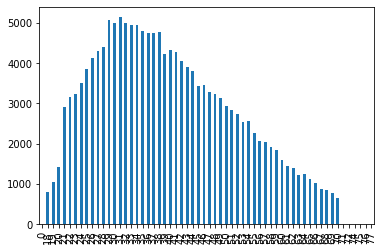

In [11]:
values = df['Age'].value_counts()
print(values.head(5))
values.sort_values().sort_index().plot(kind="bar")
age_groups = pd.cut(df['Age'], bins=[19, 40, 65, np.inf])
df.groupby(age_groups)['Age'].value_counts().mean()

In [12]:
df.head()

,ApplicationSignedHour,ApplicationSignedWeekday,VerificationType,AppliedAmount,LanguageCode,Age,Gender,Country,LoanDuration,MonthlyPayment,UseOfLoan,Education,MaritalStatus,NrOfDependants,EmploymentStatus,EmploymentDurationCurrentEmployer,WorkExperience,OccupationArea,HomeOwnershipType,IncomeFromPrincipalEmployer,IncomeFromPension,IncomeFromFamilyAllowance,IncomeFromSocialWelfare,IncomeFromLeavePay,IncomeFromChildSupport,IncomeOther,IncomeTotal,ExistingLiabilities,LiabilitiesTotal,RefinanceLiabilities,DebtToIncome,FreeCash,MonthlyPaymentDay,NewCreditCustomer,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsBefoleLoan,PreviousEarlyRepaymentsCountBeforeLoan
0,17,4,4.0,2125.0,1,53,1.0,EE,60,62.05,2,4.0,2.0,0,6.0,MoreThan5Years,15To25Years,1.0,1.0,0.0,301.0,0.0,53.0,0.0,0.0,0.0,354.0,8,485.09,6,26.29,10.92,12,False,1.0,500.0,590.95,0.0,0.0
2,11,5,1.0,3000.0,1,50,1.0,EE,60,84.75,3,5.0,2.0,0,5.0,MoreThan5Years,MoreThan25Years,7.0,1.0,900.0,0.0,0.0,0.0,0.0,0.0,0.0,900.0,4,736.45,0,30.58,78.80,17,False,1.0,1800.0,445.26,3000.0,1.0
3,22,3,4.0,10630.0,1,44,0.0,EE,60,268.57,3,4.0,4.0,1,5.0,UpTo3Years,MoreThan25Years,8.0,8.0,600.0,0.0,0.0,0.0,0.0,0.0,600.0,1200.0,7,905.00,3,26.71,349.43,20,True,0.0,0.0,0.00,0.0,0.0
4,15,3,3.0,1500.0,6,42,0.0,ES,60,63.53,2,2.0,1.0,0,3.0,UpTo5Years,5To10Years,1.0,2.0,863.0,0.0,0.0,0.0,0.0,0.0,0.0,863.0,1,350.00,0,7.36,449.47,1,True,0.0,0.0,0.00,1500.0,1.0
5,20,3,4.0,1595.0,6,34,1.0,ES,48,101.19,7,4.0,4.0,2,6.0,UpTo1Year,5To10Years,1.0,3.0,0.0,697.0,0.0,0.0,0.0,0.0,0.0,697.0,5,940.00,2,36.04,95.81,1,True,0.0,0.0,0.00,0.0,0.0


# Home Ownership

In [13]:
home_ownership_counts = df['HomeOwnershipType'].value_counts()
print(home_ownership_counts)

 1.0     55336
 3.0     39521
 2.0     24051
 8.0     16109
 10.0    10930
 4.0      4448
 7.0      3098
 6.0      1549
 5.0      1478
 9.0       693
 0.0        46
-1.0         3
Name: HomeOwnershipType, dtype: int64


### !!! -1 should not exist (not listed as value) -> remove lines from dataset

In [14]:
len_before = len(df.index)
df = df.loc[df['HomeOwnershipType'] != -1.0]
print(len_before-len(df.index), 'rows deleted.\n\n')

3 rows deleted.




In [15]:
home_ownership_counts = df['HomeOwnershipType'].value_counts().sort_index()
print(home_ownership_counts)

0.0        46
1.0     55336
2.0     24051
3.0     39521
4.0      4448
5.0      1478
6.0      1549
7.0      3098
8.0     16109
9.0       693
10.0    10930
Name: HomeOwnershipType, dtype: int64


<AxesSubplot:>

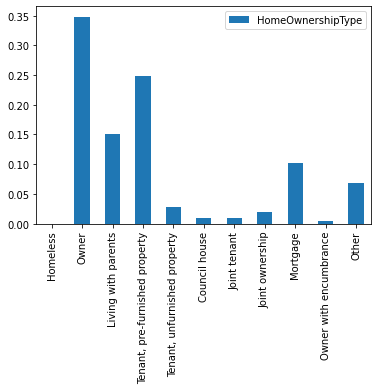

In [16]:
home_ownership_dict = {
    0.0: "Homeless", 
    1.0: "Owner", 
    2.0: "Living with parents", 
    3.0: "Tenant, pre-furnished property", 
    4.0: "Tenant, unfurnished property", 
    5.0: "Council house", 
    6.0: "Joint tenant", 
    7.0: "Joint ownership", 
    8.0: "Mortgage", 
    9.0: "Owner with encumbrance", 
    10.0: "Other"
}

home_ownership_list = pd.Index([
    "Homeless", 
    "Owner", 
    "Living with parents", 
    "Tenant, pre-furnished property", 
    "Tenant, unfurnished property", 
    "Council house", 
    "Joint tenant", 
    "Joint ownership", 
    "Mortgage", 
    "Owner with encumbrance", 
    "Other"
])

num_rows = len(df.index)
frame = home_ownership_counts.to_frame().set_index(home_ownership_list)
frame['HomeOwnershipType'] = frame['HomeOwnershipType'] / num_rows
frame.plot(kind='bar')
# sns.scatterplot(data=values.sort_values().to_frame());

In [17]:
# replace numbers 0-10 in HomeOwnershipType with actual values
df['HomeOwnershipType'] = df['HomeOwnershipType'].replace(home_ownership_dict)
print(df.head())
# group data by target
grouped = df.groupby(['TARGET']).HomeOwnershipType.value_counts().sort_index()
print(grouped)

# plot grouped data
grouped.unstack(0).plot.bar()

   ApplicationSignedHour  ApplicationSignedWeekday  VerificationType  \
0                     17                         4               4.0   
2                     11                         5               1.0   
3                     22                         3               4.0   
4                     15                         3               3.0   
5                     20                         3               4.0   

   AppliedAmount  LanguageCode  Age  Gender Country  LoanDuration  \
0         2125.0             1   53     1.0      EE            60   
2         3000.0             1   50     1.0      EE            60   
3        10630.0             1   44     0.0      EE            60   
4         1500.0             6   42     0.0      ES            60   
5         1595.0             6   34     1.0      ES            48   

   MonthlyPayment  UseOfLoan  Education  MaritalStatus NrOfDependants  \
0           62.05          2        4.0            2.0              0   
2     

KeyError: 'TARGET'

In [ ]:
print(df.shape)
print(df['TARGET'].head())

In [ ]:
print("0: repaid on time")
print("1: default")


class_dist = df['TARGET'].value_counts()

plt.figure(figsize=(12,3))
plt.title('Class Distribution')
plt.barh(class_dist.index, class_dist.values)
plt.yticks([0, 1])

for i, value in enumerate(class_dist.values):
    plt.text(value-2000, i, str(value), fontsize=12, color='white',
             horizontalalignment='right', verticalalignment='center')

plt.show()


In [ ]:
# Displaying the number of unique values in each column
for column in df.columns:
    print("{}\t: {}".format(column, len(np.unique(df[column]))))
plt.show()

In [ ]:

plt.figure(figsize=(24,20))
sns.heatmap(df.corr(), annot=True, cmap='RdBu')
plt.show()